<a href="https://colab.research.google.com/github/peterbabulik/synthetic/blob/main/Quantum_L_System_Circuit_Evolution01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install cirq --quiet

Using device: cpu


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Training quantum synthetic AI...


Training AI:   0%|          | 0/100 [00:00<?, ?it/s]


Evolving quantum circuit for target function...


Evolving circuit:   0%|          | 0/50 [00:00<?, ?it/s]

Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(0), cirq.LineQubit(0), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(0), cirq.LineQubit(0), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(0), cirq.LineQubit(0), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(0), cirq.LineQubit(0), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(1), cirq.LineQubit(1), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.TOFFOLI>. Expected unique qids but got <(cirq.LineQubit(1), cirq.LineQubit(1), cirq.LineQubit(2))>.
Error during circuit execution: Duplicate qids for <cirq.T

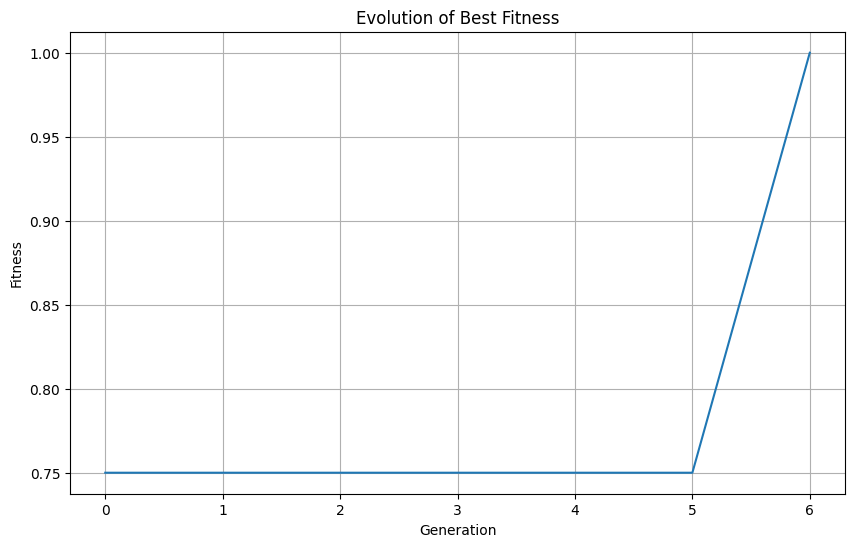


Best quantum circuit found:
Step 1: AND at (0.9839849797127717, 0.7915608231650808, 0.31416824548521305), inputs: [0, 1], theta: 1.98
Step 2: OR at (0.44530775476810724, 0.25148709963687055, 0.5759740711070424), inputs: [1, 2], theta: 5.25
Step 3: AND at (0.04396471986492412, 0.34322141264523454, 0.041051302092202646), inputs: [1, 0], theta: 1.35

Final fitness: 1.0
Logical ability: 0.5001

Testing the best quantum circuit:
Inputs: (False, False), Circuit Output: False, Expected Output: False
Inputs: (False, True), Circuit Output: False, Expected Output: False
Inputs: (True, False), Circuit Output: False, Expected Output: False
Inputs: (True, True), Circuit Output: True, Expected Output: True


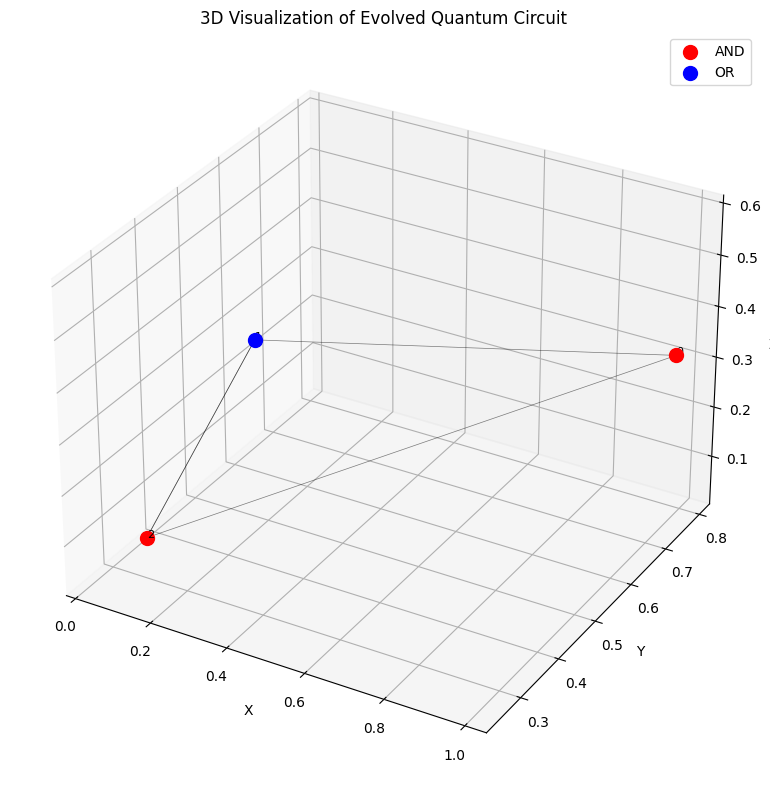

In [10]:
# !pip install cirq numpy matplotlib torch tqdm

import cirq
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple, Dict, Callable
import itertools
import random
from tqdm.notebook import tqdm
from IPython.display import display, HTML, Math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class QuantumLogicalOperation:
    def __init__(self, operation: str, coordinate: Tuple[float, float, float], inputs: List[int], quantum_params: Dict):
        self.operation = operation
        self.coordinate = coordinate
        self.inputs = inputs
        self.output = None
        self.quantum_params = quantum_params

class QuantumCircuit:
    def __init__(self, operations: List[QuantumLogicalOperation], input_map: Dict[int, bool]):
        self.operations = operations
        self.input_map = input_map
        self.fitness = 0.0
        self.num_qubits = len(input_map) + len(operations)
        self.qubits = cirq.LineQubit.range(self.num_qubits)
        self.noise_model = cirq.depolarize(p=0.01)

    def to_cirq_circuit(self):
        circuit = cirq.Circuit()

        # Initialize input qubits
        for i, val in self.input_map.items():
            if val:
                circuit.append(cirq.X(self.qubits[i]))

        # Apply operations
        for i, op in enumerate(self.operations):
            input_qubits = [self.qubits[inp] for inp in op.inputs]
            output_qubit = self.qubits[len(self.input_map) + i]

            if op.operation == "AND":
                circuit.append(cirq.TOFFOLI(*input_qubits[:2], output_qubit))
            elif op.operation == "OR":
                circuit.append(cirq.X(input_qubits[0]))
                circuit.append(cirq.X(input_qubits[1]))
                circuit.append(cirq.TOFFOLI(*input_qubits[:2], output_qubit))
                circuit.append(cirq.X(output_qubit))
                circuit.append(cirq.X(input_qubits[0]))
                circuit.append(cirq.X(input_qubits[1]))
            elif op.operation == "NOT":
                circuit.append(cirq.CNOT(input_qubits[0], output_qubit))
                circuit.append(cirq.X(output_qubit))
            elif op.operation == "XOR":
                circuit.append(cirq.CNOT(input_qubits[0], output_qubit))
                circuit.append(cirq.CNOT(input_qubits[1], output_qubit))

            angle = 2 * np.pi * op.quantum_params.get('theta', 0)
            circuit.append(cirq.rz(rads=float(angle))(output_qubit))

        circuit.append(cirq.measure(self.qubits[-1], key='result'))
        return circuit

class QuantumSyntheticAI:
    def __init__(self, population_size: int = 50, mutation_rate: float = 0.2):
        self.logical_ability = torch.tensor([0.0], device=device)
        self.operation_regions = self._initialize_operation_regions()
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.simulator = cirq.Simulator()

    def _initialize_operation_regions(self):
        return {
            "AND": torch.rand(3, device=device),
            "OR": torch.rand(3, device=device),
            "NOT": torch.rand(3, device=device),
            "XOR": torch.rand(3, device=device)
        }

    def train(self):
        self.logical_ability += torch.rand(1, device=device) * 0.01
        self.logical_ability = torch.clamp(self.logical_ability, 0, 1)

    def calculate_operation_affinity(self, operation, coordinate):
        op_region = self.operation_regions[operation]
        coordinate_tensor = torch.tensor(coordinate, device=device)
        distance = torch.norm(op_region - coordinate_tensor)
        affinity = 1 / (1 + distance)
        return affinity.item()

    def execute_quantum_circuit(self, circuit: QuantumCircuit) -> bool:
        cirq_circuit = circuit.to_cirq_circuit()
        result = self.simulator.run(cirq_circuit, repetitions=100)
        # Get the most common measurement result
        measurements = result.measurements['result']
        return np.mean(measurements) > 0.5

    def generate_random_circuit(self, num_operations: int, num_inputs: int) -> QuantumCircuit:
        operations = []
        input_map = {i: False for i in range(num_inputs)}

        for i in range(num_operations):
            op = random.choice(list(self.operation_regions.keys()))
            coord = tuple(random.random() for _ in range(3))

            if op == "NOT":
                num_inputs_needed = 1
            else:
                num_inputs_needed = 2

            if i == 0:
                inputs = [random.randint(0, num_inputs-1) for _ in range(num_inputs_needed)]
            else:
                available_inputs = list(range(num_inputs)) + list(range(num_inputs, num_inputs + i))
                inputs = random.sample(available_inputs, num_inputs_needed)

            quantum_params = {
                'theta': random.random() * 2 * np.pi
            }

            operations.append(QuantumLogicalOperation(op, coord, inputs, quantum_params))

        return QuantumCircuit(operations, input_map)

    def mutate_circuit(self, circuit: QuantumCircuit) -> QuantumCircuit:
        new_operations = []
        for i, op in enumerate(circuit.operations):
            if random.random() < self.mutation_rate:
                new_op = random.choice(list(self.operation_regions.keys()))
                new_coord = tuple(random.random() for _ in range(3))

                if new_op == "NOT":
                    num_inputs_needed = 1
                else:
                    num_inputs_needed = 2

                available_inputs = list(range(len(circuit.input_map))) + list(range(len(circuit.input_map), len(circuit.input_map) + i))
                new_inputs = random.sample(available_inputs, num_inputs_needed)

                new_quantum_params = {
                    'theta': op.quantum_params['theta'] + random.gauss(0, 0.1)
                }
                new_operations.append(QuantumLogicalOperation(new_op, new_coord, new_inputs, new_quantum_params))
            else:
                new_operations.append(op)
        return QuantumCircuit(new_operations, circuit.input_map.copy())

    def crossover(self, parent1: QuantumCircuit, parent2: QuantumCircuit) -> QuantumCircuit:
        split_point = random.randint(1, len(parent1.operations) - 1)
        child_operations = parent1.operations[:split_point] + parent2.operations[split_point:]
        child_input_map = parent1.input_map.copy()
        return QuantumCircuit(child_operations, child_input_map)

    def evolve_circuit(self, target_function: Callable, generations: int = 100, num_operations: int = 10, num_inputs: int = 4):
        def fitness(circuit):
            correct_outputs = 0
            total_tests = 0
            for inputs in itertools.product([False, True], repeat=num_inputs):
                circuit.input_map = {i: val for i, val in enumerate(inputs)}
                try:
                    circuit_output = self.execute_quantum_circuit(circuit)
                    if circuit_output == target_function(inputs):
                        correct_outputs += 1
                    total_tests += 1
                except Exception as e:
                    print(f"Error during circuit execution: {e}")
                    continue
            return correct_outputs / total_tests if total_tests > 0 else 0

        population = [self.generate_random_circuit(num_operations, num_inputs) for _ in range(self.population_size)]
        best_fitnesses = []

        for generation in tqdm(range(generations), desc="Evolving circuit"):
            for circuit in population:
                circuit.fitness = fitness(circuit)

            population.sort(key=lambda x: x.fitness, reverse=True)
            best_circuit = population[0]
            best_fitnesses.append(best_circuit.fitness)

            if best_circuit.fitness >= 0.95:  # Relaxed condition for "perfect" solution
                print(f"Near-perfect solution found in generation {generation}")
                self.plot_fitness_evolution(best_fitnesses)
                return best_circuit

            new_population = population[:self.population_size // 2]

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate_circuit(child)
                new_population.append(child)

            population = new_population

            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_circuit.fitness}")

        print("No perfect solution found, returning best circuit")
        self.plot_fitness_evolution(best_fitnesses)
        return population[0]

    def plot_fitness_evolution(self, fitnesses):
        plt.figure(figsize=(10, 6))
        plt.plot(fitnesses)
        plt.title('Evolution of Best Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

    def visualize_circuit_3d(self, circuit: QuantumCircuit):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        color_map = {
            "AND": "red",
            "OR": "blue",
            "NOT": "green",
            "XOR": "purple"
        }

        for i, op in enumerate(circuit.operations):
            x, y, z = op.coordinate
            ax.scatter(x, y, z, c=color_map[op.operation], s=100, label=op.operation if op.operation not in ax.get_legend_handles_labels()[1] else "")
            ax.text(x, y, z, f"{i}", fontsize=8)

            for input_idx in op.inputs:
                if input_idx < len(circuit.operations):
                    input_op = circuit.operations[input_idx]
                    ax.plot([x, input_op.coordinate[0]],
                            [y, input_op.coordinate[1]],
                            [z, input_op.coordinate[2]],
                            'k-', linewidth=0.5, alpha=0.5)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Visualization of Evolved Quantum Circuit')
        ax.legend()
        plt.tight_layout()
        plt.show()

def display_mathematical_background():
    display(HTML("<h2>Quantum L-System Circuit Evolution</h2>"))
    display(Math(r"\text{1. Quantum Gates: } U(\theta) = e^{-i\theta\sigma_z/2}"))
    display(Math(r"\text{2. L-System Grammar: } G = (V, \omega, P)"))
    display(Math(r"\text{3. Evolutionary Fitness: } f(c) = \frac{1}{2^n}\sum_{i=1}^{2^n} \delta(c(x_i), y_i)"))

# Example usage
def main():
    display_mathematical_background()

    ai = QuantumSyntheticAI(population_size=20)
    print("Training quantum synthetic AI...")
    for _ in tqdm(range(100), desc="Training AI"):
        ai.train()

    def target_function(inputs):
        return inputs[0] and inputs[1]  # Simplified target function

    print("\nEvolving quantum circuit for target function...")
    best_circuit = ai.evolve_circuit(target_function, generations=50, num_operations=3, num_inputs=2)

    print("\nBest quantum circuit found:")
    for i, op in enumerate(best_circuit.operations):
        print(f"Step {i+1}: {op.operation} at {op.coordinate}, inputs: {op.inputs}, theta: {op.quantum_params['theta']:.2f}")

    print(f"\nFinal fitness: {best_circuit.fitness}")
    print(f"Logical ability: {ai.logical_ability.item():.4f}")

    print("\nTesting the best quantum circuit:")
    for inputs in itertools.product([False, True], repeat=2):
        best_circuit.input_map = {i: val for i, val in enumerate(inputs)}
        circuit_output = ai.execute_quantum_circuit(best_circuit)
        expected_output = target_function(inputs)
        print(f"Inputs: {inputs}, Circuit Output: {circuit_output}, Expected Output: {expected_output}")

    ai.visualize_circuit_3d(best_circuit)

if __name__ == "__main__":
    main()